In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.special as special

In [ ]:
# true metric
p_star = (0.8,0.2)
q_star = (0.3,0.1,0.3)

def eta(x):
  return 1/(1+np.exp(5*x))

zeta = 0.5  # f_X /sim U(-1,1)

# implementation of proposition 1
# return a classifier with t
def h_bar(t):
  m11, m00 = np.cos(t), np.sin(t)
  def hb(x):
    if m11+m00 >= 0:
      return int(eta(x)>=m00/(m11+m00))
    else:
      return int(eta(x)<=m00/(m11+m00))
  return hb

# confusion matrix, analytical solution
def C11(t):  # P(Y=1, h=1)
  m11,m00 = np.cos(t), np.sin(t)
  x_prime = 0.
  h = h_bar(t)
  if m00 == 0:
    x_prime = 1
  elif (m00+m11)/m00-1 <= 0:
    x_prime = -1
  else:
    x_prime = np.log(m11/m00)/5
    if x_prime > 1:
      x_prime = 1
    elif x_prime < -1:
      x_prime = -1
  if m00+m11 >= 0:
    return 0.5*(x_prime-0.2*np.log(1+np.exp(5*x_prime))+1+0.2*np.log(1+np.exp(-5))) # x-0.2ln(1+e^5x)
  else:
    return 0.5*(1-0.2*np.log(1+np.exp(5))-x_prime+0.2*np.log(1+np.exp(5*x_prime)))

def C10(t):  # P(Y=0, h=1)
  return 0.5-C11(t)

def C01(t):  # P(Y=1, h=0)
  return 0.5-C00(t)

def C00(t):  # P(Y=0, h=0)
  m11,m00 = np.cos(t), np.sin(t)
  x_prime = 0
  h = h_bar(t)
  if m00 == 0:
    x_prime = 1
  elif (m00+m11)/m00-1 <= 0:
    x_prime = -1
  else:
    x_prime = np.log(m11/m00)/5
    if x_prime > 1:
      x_prime = 1
    elif x_prime < -1:
      x_prime = -1
  if m00+m11 >= 0:
    return 0.5*(0.2*np.log(1+np.exp(5))-0.2*np.log(1+np.exp(5*x_prime)))  # ln(1+e^5x)
  else:
    return 0.5*(0.2*np.log(1+np.exp(5*x_prime))-0.2*np.log(1+np.exp(-5)))

# metric evaluation
def phi(t):
  return (p_star[0]*C11(t)+p_star[1]*C00(t))/(q_star[0]*C11(t)+q_star[1]*C00(t)+q_star[2])

# query function (always maximize phi function)
# alpha: error rate —— with probability alpha, the oracle will return wrong answer
def query(t_1, t_2, alpha):
  if phi(t_1) < phi(t_2):
    if np.random.rand() > alpha:
      return 1  # prefer t2
    else:
      return 0
  else:
    if np.random.rand() > alpha:
      return 0  # prefer t1
    else:
      return 1

# Algorithm 1

In [ ]:
# implements algorithm 1
# analytical version
# alpha: error rate of oracle
def max_quasiconcave_metric(eps, alpha):
  t_a = 0
  t_b = np.pi/2
  m_bar = np.zeros(2)
  C_bar = 0
  iter = 0
  while np.linalg.norm(t_a-t_b) > eps:
    # divide the searching range into equally seperated intervals
    t_c = (3*t_a+t_b)/4
    t_d = (t_a+t_b)/2
    t_e = (t_a+3*t_b)/4
    # compute Confusion Matrices
    C_a = np.array([[C00(t_a), C01(t_a)],[C10(t_a), C11(t_a)]])
    C_b = np.array([[C00(t_b), C01(t_b)],[C10(t_b), C11(t_b)]])
    C_c = np.array([[C00(t_c), C01(t_c)],[C10(t_c), C11(t_c)]])
    C_d = np.array([[C00(t_d), C01(t_d)],[C10(t_d), C11(t_d)]])
    C_e = np.array([[C00(t_e), C01(t_e)],[C10(t_e), C11(t_e)]])
    # pairwise comparisons
    ca = query(t_c, t_a, alpha)
    dc = query(t_d, t_c, alpha)
    ed = query(t_e, t_d, alpha)
    be = query(t_b, t_e, alpha)
    # determine the next iter search range based on oracle resposne to query
    if ca:
      t_b = t_d
    elif not ca and dc:
      t_b = t_d
    elif not dc and ed:
      t_a = t_c
      t_b = t_e
    elif not ed and be:
      t_a = t_d
    else:
      t_a = t_d
    m_bar[0], m_bar[1] = np.cos(t_d), np.sin(t_d)
    C_bar = C_d
    iter += 1
  # print("iteration run:"+str(iter))
  return m_bar,C_bar

# Algorithm 2

In [ ]:
# implements algorithm 1
# analytical version
# alpha: error rate of oracle
def min_quasiconvex_metric(eps, alpha):
  t_a = np.pi
  t_b = np.pi*1.5
  m_bar = np.zeros(2)
  C_bar = 0
  iter = 0
  while np.linalg.norm(t_a-t_b) > eps:
    # divide the searching range into equally seperated intervals
    t_c = (3*t_a+t_b)/4
    t_d = (t_a+t_b)/2
    t_e = (t_a+3*t_b)/4
    # compute Confusion Matrices
    C_a = np.array([[C00(t_a), C01(t_a)],[C10(t_a), C11(t_a)]])
    C_b = np.array([[C00(t_b), C01(t_b)],[C10(t_b), C11(t_b)]])
    C_c = np.array([[C00(t_c), C01(t_c)],[C10(t_c), C11(t_c)]])
    C_d = np.array([[C00(t_d), C01(t_d)],[C10(t_d), C11(t_d)]])
    C_e = np.array([[C00(t_e), C01(t_e)],[C10(t_e), C11(t_e)]])
    # pairwise comparisons
    ca = query(t_a, t_c, alpha)
    dc = query(t_c, t_d, alpha)
    ed = query(t_d, t_e, alpha)
    be = query(t_e, t_b, alpha)
    # determine the next iter search range based on oracle resposne to query
    if ca:
      t_b = t_d
    elif not ca and dc:
      t_b = t_d
    elif not dc and ed:
      t_a = t_c
      t_b = t_e
    elif not ed and be:
      t_a = t_d
    else:
      t_a = t_d
    m_bar[0], m_bar[1] = np.cos(t_d), np.sin(t_d)
    C_bar = C_d
    iter += 1
  # print("iteration run:"+str(iter))
  return m_bar,C_bar

In [ ]:
m,C = max_quasiconcave_metric(1e-4, 0.)
print("elicited metric: "+str(m))
print("confusion matrix: \n"+str(C))

elicited metric: [0.97976212 0.20016539]
confusion matrix: 
[[0.3232651  0.1767349 ]
 [0.01791831 0.48208169]]


In [ ]:
m,C = min_quasiconcex_metric(1e-4, 0.)
print("elicited metric: "+str(m))
print("confusion matrix: \n"+str(C))

elicited metric: [-0.97129901 -0.23786179]
confusion matrix: 
[[0.16192767 0.33807233]
 [0.47876679 0.02123321]]


# Algorithm 3

In [ ]:
def grid_search_for_p(m11, m00, C0, m11_, m00_, C0_, k, delta):
  sig_opt = np.inf
  p11_opt = 0
  kt = np.linspace(0, np.pi/2, k//2)+np.linspace(np.pi, np.pi*1.5, k//2)
  for p11 in np.arange(0, 1+delta, delta):
    p00 = 1-p11
    P = p11*zeta+p00*(1-zeta)
    Qp = P+C0-m11*zeta-m00*(1-zeta)
    q0p = C0*P/Qp
    q11p = (p11-m11)*P/Qp
    q00p = (p00-m00)*P/Qp
    Qpp = P+C0_-m11_*zeta-m00_*(1-zeta)
    q0pp = C0_*P/Qpp
    q11pp = (p11-m11_)*P/Qpp
    q00pp = (p00-m00_)*P/Qpp
    phip = (p11*np.array(list(map(C11, kt)))+p00*np.array(list(map(C00, kt))))/(q11p*np.array(list(map(C11, kt)))+q00p*np.array(list(map(C00, kt)))+q0p)
    phipp = (p11*np.array(list(map(C11, kt)))+p00*np.array(list(map(C00, kt))))/(q11pp*np.array(list(map(C11, kt)))+q00pp*np.array(list(map(C00, kt)))+q0pp)
    r = phip/phipp
    sig = np.std(r)
    if sig<sig_opt:
      sig_opt = sig
      p11_opt = p11
  return p11_opt

In [ ]:
ma,Ca = max_quasiconcave_metric(1e-4, 0.)
t = np.arccos(ma[0])
if t > np.pi/2:
    t = np.pi*2-t
C0 = phi(t)
mi,Ci = min_quasiconvex_metric(1e-4, 0.)
t = np.arccos(mi[0])
if t > np.pi/2:
    t = np.pi*2-t
C0_ = phi(t)
p11 = grid_search_for_p(m11=ma[0], m00=ma[1], C0=C0, m11_=mi[0], m00_=mi[1], C0_=C0_, k=2000, delta=0.01)
p00 = 1-p11
P = p11*zeta+p00*(1-zeta)
Q = P+C0-ma[0]*zeta-ma[1]*(1-zeta)
q0 = C0*P/Q
q11 = (p11-ma[0])*P/Q
q00 = (p00-ma[1])*P/Q
print((p11,p00)+(q11,q00,q0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


(0.77, 0.22999999999999998, -0.12278324212891577, 0.017463543390885097, 0.5526598493690152)


In [86]:
p00 = 1-p11
P = p11*zeta+p00*(1-zeta)
Q = P+C0_-mi[0]*zeta-mi[1]*(1-zeta)
q0 = C0_*P/Q
q11 = (p11-mi[0])*P/Q
q00 = (p00-mi[1])*P/Q
print((p11,p00)+(q11,q00,q0))

(0.77, 0.22999999999999998, 0.69228700173688, 0.18600747856042157, 0.060852759851349185)


In [87]:
p11 = 0.77
p00 = 1-p11
P = p11*zeta+p00*(1-zeta)
Q = P+C0-ma[0]*zeta-ma[1]*(1-zeta)
q0 = C0*P/Q
q11 = (p11-ma[0])*P/Q
q00 = (p00-ma[1])*P/Q
print((p11,p00)+(q11,q00,q0))

(0.77, 0.22999999999999998, -0.12278324212891577, 0.017463543390885097, 0.5526598493690152)


# Visualize $\phi$

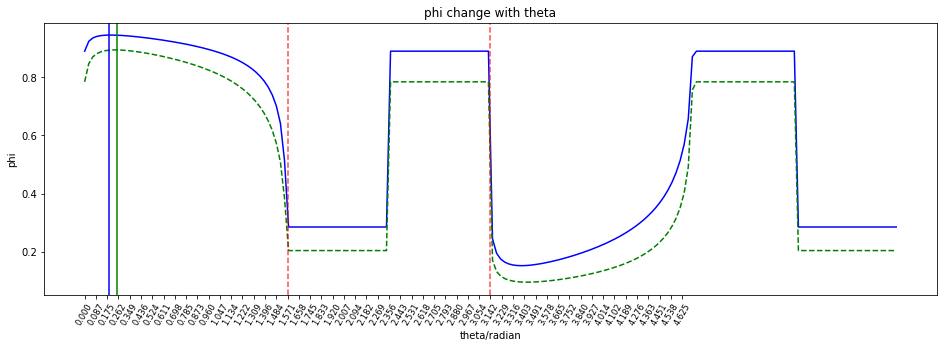

In [88]:
# Plot phi function versus different thetas
def phi_elicited(t):
  return (p11*C11(t)+p00*C00(t))/(q11*C11(t)+q00*C00(t)+q0)

thetas = np.linspace(0,np.pi*2,200)
ph_true = list(map(phi, thetas))
ph_elicited = list(map(phi_elicited, np.linspace(0,np.pi*2,200)))

plt.figure(figsize=(16,5))
plt.plot(thetas, ph_true, "-", color='b')
plt.plot(thetas, ph_elicited, "--", color='g')

for p in np.arange(0.5, 1.5, 0.5):
  plt.axvline(x=np.pi*p, c='r', ls='--', alpha=0.7)

plt.axvline(x=thetas[np.argmax(ph_true)], c='b')
plt.axvline(x=thetas[np.argmax(ph_elicited)], c='g')

plt.xticks(np.arange(0, np.pi*1.5, np.pi/36), rotation=60, size="small")
plt.title("phi change with theta")
plt.xlabel("theta/radian")
plt.ylabel("phi")
plt.show()